In [1]:
# load required packages
import numpy as np
from sklearn.metrics import r2_score
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusRegressor
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import  AloRFPlusMDI
from subgroup_detection import detect_subgroups, compute_rbo_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# simulate data from two groups
np.random.seed(0)
group_size = 1000
train_group_size = int(0.8*group_size)
test_group_size = int(0.2*group_size)

# Group 1: \beta_1 = 10, all other \beta_i = 0
X_group_1 = np.random.normal(0, 1, (group_size, 10))
beta_group1 = np.array([10,0,0,0,0,0,0,0,0,0])
y_group1 = np.dot(X_group_1, beta_group1) + np.random.normal(0, 0.1, group_size)

# Group 2: \beta_2 = 10, all other \beta_i = 0
X_group_2 = np.random.normal(0, 1, (group_size, 10))
beta_group2 = np.array([0,10,0,0,0,0,0,0,0,0])
y_group2 = np.dot(X_group_2, beta_group2) + np.random.normal(0, 0.1, group_size)

# split into train and test
X_train = np.vstack((X_group_1[:train_group_size,:], X_group_2[:train_group_size,:]))
y_train = np.hstack((y_group1[:train_group_size], y_group2[:train_group_size]))
X_test = np.vstack((X_group_1[test_group_size:,:], X_group_2[test_group_size:,:]))
y_test = np.hstack((y_group1[test_group_size:], y_group2[test_group_size:]))

In [3]:
# fit RF+ model
rf_plus = RandomForestPlusRegressor()
rf_plus.fit(X_train, y_train)

# predict
y_pred = rf_plus.predict(X_test)
r2_score(y_test, y_pred)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.

0.6489058569113206

In [4]:
mdi_explainer = AloRFPlusMDI(rf_plus,evaluate_on='oob')
mdi, partial_preds = mdi_explainer.explain(X_train[:], y_train[:])
mdi_rankings = mdi_explainer.get_rankings(mdi)

In [5]:
group1_mdi, group2_mdi = mdi[:train_group_size], mdi[train_group_size:]
group1_rank, group2_rank = mdi_rankings[:train_group_size], mdi_rankings[train_group_size:]
group1_av_mdi, group2_av_mdi = np.mean(mdi[:train_group_size],axis = 0), np.mean(mdi[train_group_size:],axis = 0)
group1_av_rank, group2_av_rank = np.mean(mdi_rankings[:train_group_size],axis = 0), np.mean(mdi_rankings[train_group_size:],axis = 0)
group2_av_rank = np.mean(mdi_rankings[train_group_size:],axis = 0)
group1_av_rank, group2_av_rank

(array([0.5525 , 3.5375 , 5.26125, 5.555  , 5.77   , 5.49875, 5.17875,
        5.32125, 5.125  , 3.2    ]),
 array([1.21375, 3.63375, 5.19125, 5.45875, 5.395  , 5.50125, 5.45875,
        5.3675 , 5.23125, 2.54875]))

/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


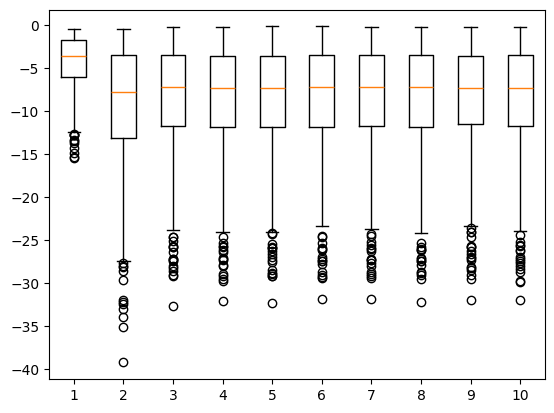

In [6]:
plt.boxplot(group1_mdi)
plt.show()

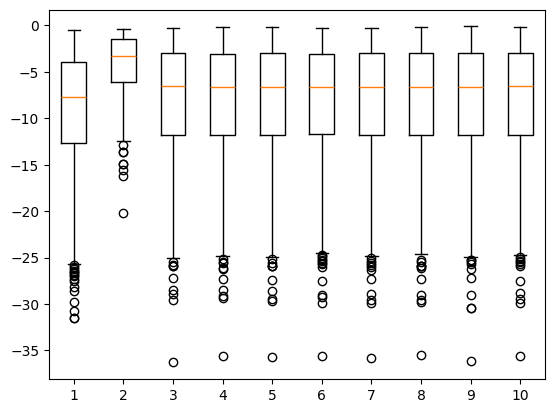

In [7]:
plt.boxplot(group2_mdi)
plt.show()

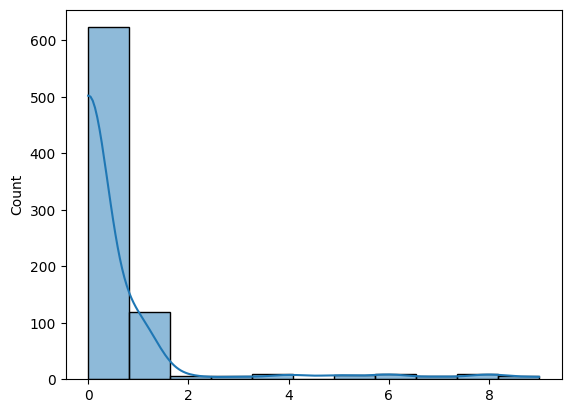

In [8]:
sns.histplot(group1_rank[:, 0], kde = True)
plt.show()

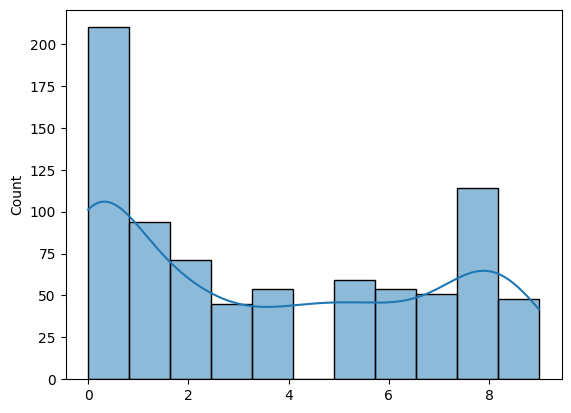

In [9]:
sns.histplot(group2_rank[:, 1], kde = True)
plt.show()

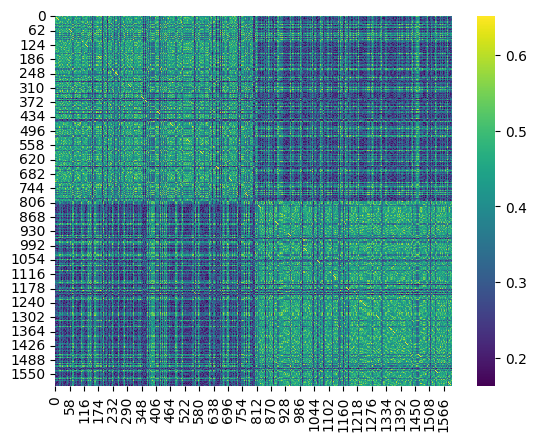

In [10]:
rbo_matrix = compute_rbo_matrix(mdi_rankings, p = 0.9)
sns.heatmap(rbo_matrix, cmap='viridis')
plt.show()

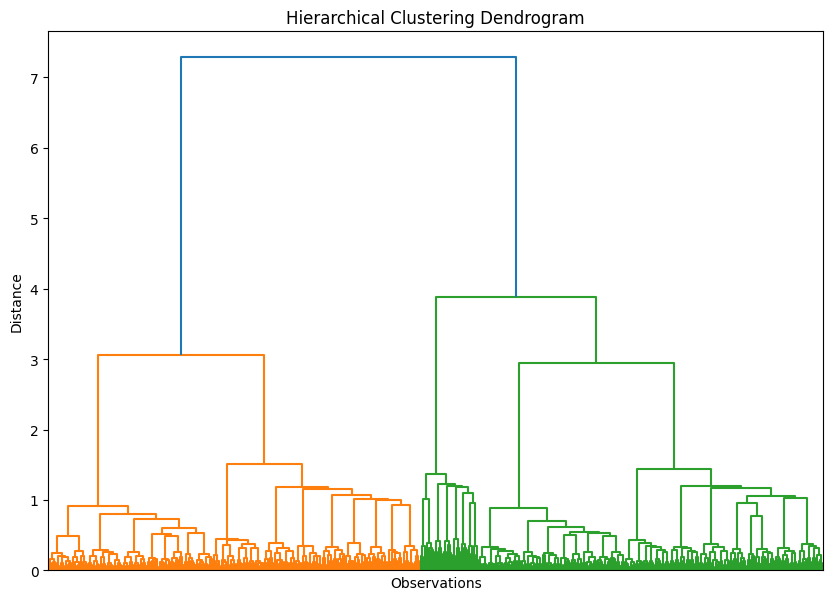

In [11]:
clusters = detect_subgroups(rbo_matrix)

In [12]:
group1_clust = clusters[:400]
group2_clust = clusters[400:]
print((group1_clust==1).mean())
print((group1_clust==2).mean())
print((group2_clust==1).mean())
print((group2_clust==2).mean())

0.155
0.845
0.5891666666666666
0.41083333333333333
